# Matlab Basic Usage

This notebook shows the usage of the Matlab ripser API via several examples

## Two Noisy Circles with/without A Threshold

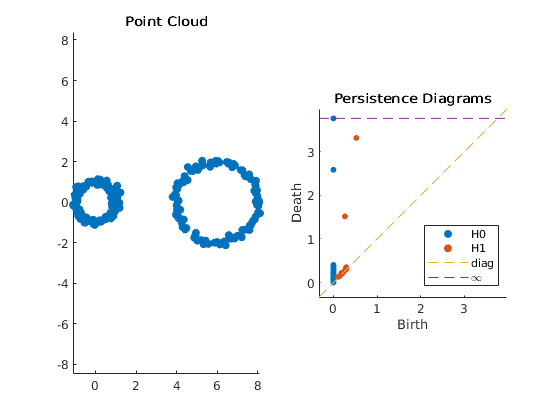

In [1]:
% Make a dataset with two noisy circles
NSamples = 100;
t = linspace(0, 2*pi, NSamples);
X = zeros(NSamples, 2);
X(:, 1) = cos(t);
X(:, 2) = sin(t);
X = [X; bsxfun(@plus, 2*X, [6, 0])];
X = X + 0.1*randn(2*NSamples, 2);

% Run 0D and 1D persistent homology on this dataset and plot the results
dgms = ripserPC(X, 'maxdim', 1);

% Plot the results
subplot(121);
scatter(X(:, 1), X(:, 2), 'fill');
axis equal;
title('Point Cloud');
subplot(122);
plotDGMs(dgms);
title('Persistence Diagrams');

Now we'll change the threshold to be below the death of the most persistent point in H1, by passing in a fourth parameter

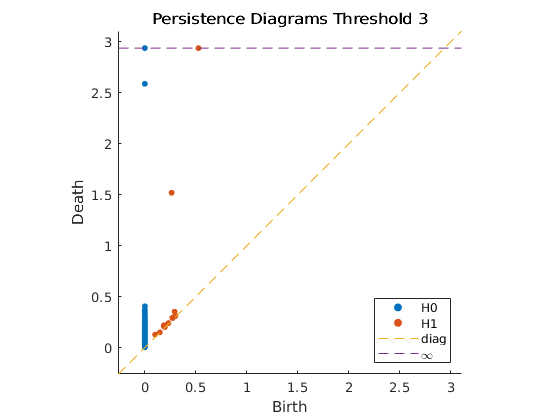

In [2]:
thresh = 3.0;
dgms = ripserPC(X, 'maxdim', 1, 'thresh', thresh);
plotDGMs(dgms);
title(sprintf('Persistence Diagrams Threshold %.3g', thresh));

Notice how a point in H1 which was alive before now has an infinite death time, because its killing edge has not been added yet.

Note that it is also possible to pass a dense or sparse distance matrix along to a different ripser function "ripserDM."  We'll show how to use a sparse matrix as an alternative to using a threshold, by zeroing out all edges above a threshold that we want

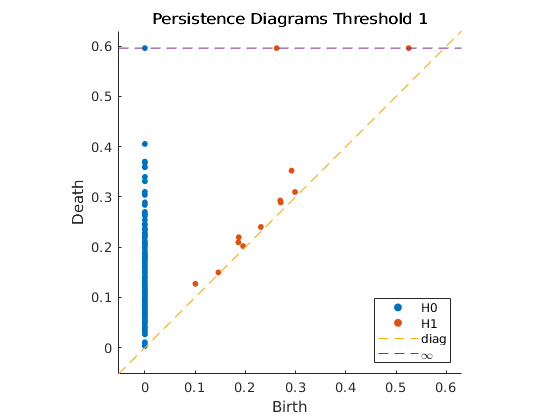

In [3]:
D = pdist2(X, X);
thresh = 1.0;
D(D > thresh) = 0;
D = sparse(D);
dgms = ripserDM(D, 'maxdim', 1);
plotDGMs(dgms);
title(sprintf('Persistence Diagrams Threshold %.3g', thresh));

## 2D Homology And Beyond

Let's now look at an example of 2D homology.  We'll sample some points evenly on the torus.

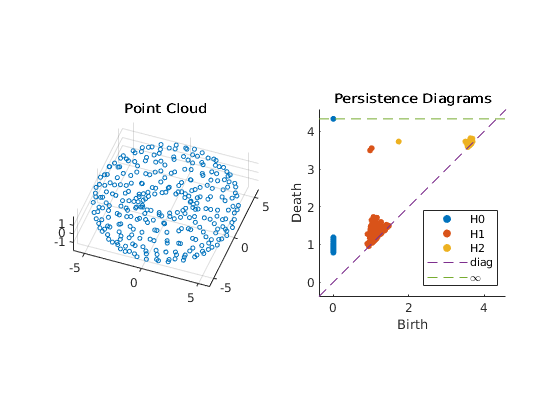

In [4]:
R = 4;
r = 2;
N = 10000; %Number of initial points in (theta, phi) space
NPoints = 300; %Number of points to evenly subsample in 3D
theta = rand(N, 1)*2*pi;
phi = rand(N, 1)*2*pi;
X = zeros(N, 3);
X(:, 1) = (R + r*cos(theta)).*cos(phi);
X(:, 2) = (R + r*cos(theta)).*sin(phi);
X(:, 3) = r*sin(theta);

perm = zeros(1, NPoints);
perm(1) = 1;
lambdas = zeros(1, NPoints);
ds = pdist2(X(1, :), X);
for ii = 2:NPoints
    [~, idx] = max(ds);
    perm(ii) = idx;
    lambdas(ii) = ds(idx);
    ds = min(ds, pdist2(X(idx, :), X));
end
[perm, idx] = sort(perm);
lambdas = lambdas(idx);
Y = X(perm, :);

dgms = ripserPC(Y, 'maxdim', 2); %Do up to 2D homology
subplot(121)
scatter3(Y(:, 1), Y(:, 2), Y(:, 3), 10);
title('Point Cloud');
axis equal;
view(20, 45)
subplot(122);
plotDGMs(dgms);
title('Persistence Diagrams');

Notice how there are 2 points in H1 (2 independent loops) and 1 point in H2 (1 independent void), which is indeed the signature of a torus

## Changing Field Coefficients

By default, the ripser computations take place with $\mathbb{Z}/2\mathbb{Z}$ coefficients, but it is possible to use other fields.  To demonstrate this, we'll sample some points on the projective plane by randomly sampling points on the sphere and applying the quotient map $x \sim -x$.  Note that in this example we're actually using "ripserDM" instead of "ripserPC" because we're using a non-euclidean distance measurement which is the arc length on the projective plane,  $\cos^{-1}(|x \cdot y|)$

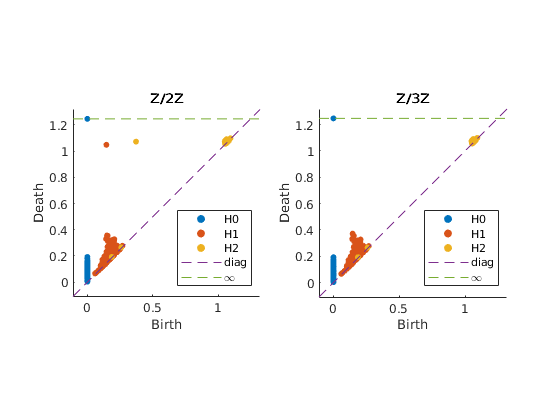

In [5]:
% Randomly sample points on the 2-sphere
X = randn(400, 3);
X = bsxfun(@times, X, 1./sqrt(sum(X.^2, 2)));
% Construct the distance matrix on the projective plane by performing
% an antipodal identification
D = acos(abs(X*X')); 
% Compute ripser up to H2 with Z/2Z coefficients
dgms2 = ripserDM(D, 'maxdim', 2, 'coeff', 2);
% Recompute risper with Z/3Z coefficients
dgms3 = ripserDM(D, 'maxdim', 2, 'coeff', 3);

subplot(121);
plotDGMs(dgms2);
title("Z/2Z");
subplot(122);
plotDGMs(dgms3);
title("Z/3Z");

Notice how the result changes from 1 persistent H1 class and 1 persistent H2 class to none when changing from $\mathbb{Z}/2\mathbb{Z}$ to $\mathbb{Z}/3\mathbb{Z}$.  This is what's supposed to happen with the projective plane.

## Lower star image filtrations


There is also a function which constructs a 0-dimension lower star filtration on an image. It constructs a sparse distance matrix in which every pixel in the image is a vertex, and every vertex is connected to its 8 spatial neighbors (unless it's at the boundary, in which case there may be fewer). The edge weights are taken to be the maximum of the two pixel values they connect (hence the "lower star").

In spite of the large number of pixels, this code will be fast (nearly linear in the number of pixels), as there are a linear number of edges in the number of pixels, and only 0-dimension homology is computed.

### Gaussian Blob Example

Now, let's test out this code on an example with an image containing some Gaussian blobs. We will put three negative Gaussians in this image; one which reaches its local min at -3, one at -2, and one at -1:



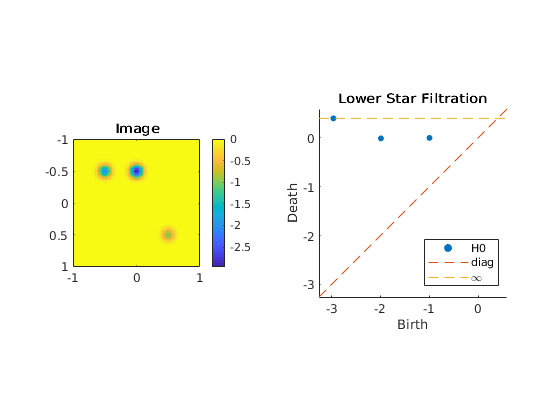

In [6]:
pix = linspace(-1, 1, 100);
[X, Y] = meshgrid(pix, pix);
I = -1*exp(-((X-0.5).^2 + (Y-0.5).^2)/(0.1^2));
I = I - 2*exp(-((X+0.5).^2 + (Y+0.5).^2)/(0.1^2));
I = I - 3*exp(-((X).^2 + (Y+0.5).^2)/(0.1^2));

dgms = lowerStarImg(I);
subplot(121);
imagesc(pix, pix, I);
axis equal;
xlim([pix(1), pix(end)]);
ylim([pix(1), pix(end)]);
colorbar;
title('Image');
subplot(122);
plotDGMs(dgms);
title('Lower Star Filtration');